In [1]:
# TO DO : 
#DONE ----- Normalize Relaxation data
#DONE ----- Create summary sheets for Penetration and Relaxation Data
#DONE ----- Create point of first contact
#DONE ----- Create FC to RP penetration Regime
#DONE -----    # Zero to FC as 0.00 extension?
#DONE -----    #Create Penetration Regime Summary File (All indexed/reset to 0)
                #Insert Time/Extension Reference Cell                               #<------------------------------------
# Create summary file/sheet with:
    # Firct Contact, FC Smooth, MP, MP Smooth, RP, RP Smooth, 
    # Polyfit Alpha and Beta
    # Near-Field and Wide-Field Relaxation Summary files?
#Calculate Tip Penetration Resistance (q_c) 
    #How does it vary fore different angle of frction (phi, Φ) or ice morphology?
# Plot with Resistance/Load on top X-axis, then depth going from 0 to base on Y-Axis
# Edit Combined Figure so that it has highlighted background like Regimes in 2018 Atkinson UCS paper

# Ensure the relaxing times for each sample are similar? Sometimes theyre different?

# Understand what Atkinson Penetration and Relaxation models represent/reflect??
    # Should I use his Penetratiuon model or Q_c?

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import os
import statistics
from scipy.stats import mode
import openpyxl

#For self checking and code development
import datetime

################################################################################
################################################################################
#                         Define Functions
################################################################################
################################################################################

# Define the function to read in a data file and return a cleaned dataframe
def read_data_file(filepath):
    # read the csv file into a pandas dataframe
    df = pd.read_csv(filepath).drop([0]).astype(float)

    # Make sure Time is 0.00 (The Exported .CSV files have Time since program opened, not actual test time)
    # Round it to 2 decimal points, to assist with comparing different data
    df['Time'] = df['Time'] - df.iloc[0]['Time']
    df['Time'] = df['Time'].round(2)

    # Make sure Extension is 2 decimal points, to assist with determining Relaxation Point (RP)
    df['Extension'] = df['Extension'].round(2)

    return df

# Define the function to find the relaxation point
def find_relaxation_point(df):
    mode_value = mode(df['Extension'])[0][0]
    relaxation_point_index = df['Extension'].index[df['Extension'] == mode_value][0] - 1
    return relaxation_point_index

def slice_and_smooth(df, relaxation_point_index):
    ########################################################################
    #######         Slicing
    ########################################################################
    
    #Slice raw data based on Relaxation Point
    df['Penetration Regime Load Sliced'] = df['Load'][:relaxation_point_index]
    
    #Slice data from from Relaxation Point to End --- include -1 so that it INCLUDES RP_index 
    df['Relaxation Regime Load Sliced'] = df['Load'][relaxation_point_index - 1:]
    
    ########################################################################
    ####### Penetration Regime Smoothing
    ########################################################################
    
    # For SavGol Filtering, allocate Raw Penetration Regime Sliced data as a variable
    penetration_regime_load = df['Load'][:relaxation_point_index]

    # Apply Savgol filter with window length 21 and polynomial order 3
    penetration_regime_load_smoothed = savgol_filter(penetration_regime_load, window_length=11, polyorder=2)

    # Assign smoothed values to a new column in df
    df['Load Smoothed'] = np.concatenate((penetration_regime_load_smoothed, np.full((len(df) - len(penetration_regime_load_smoothed)), np.nan)))

    #relaxation_point_load_smoothed = df.loc[relaxation_point_index, 'Load Smoothed']
        
    ########################################################################
    ####### Relaxation Regime Smoothing
    ########################################################################
    #Determine Start time (0.00 sec) of Relaxation Regime based on Relaxation Point Index in Raw Data
    df['Relaxing Time'] = df['Time'] - df.loc[relaxation_point_index, 'Time']
    df['Relaxing Time'] = df['Relaxing Time'].round(3)

    #Create new dataframe 
    df_relax = df.loc[relaxation_point_index:, ['Relaxing Time','Relaxation Regime Load Sliced']].reset_index(drop=True)

    #Smooth Relaxation Regime Data
    df_relax['Relaxation Regime Load Smoothed'] = savgol_filter(df_relax ['Relaxation Regime Load Sliced'], window_length=11, polyorder=2, mode='nearest')

    # Replace the first value of the smoothed load column with the first value of the sliced load column
    df_relax.loc[0, 'Relaxation Regime Load Smoothed'] = df_relax .loc[0, 'Relaxation Regime Load Sliced']
    
    #Determine Normalized Load Raw Data against Load value at Relaxation Point Index in Raw Data
    df_relax['Normalized Load Raw'] = df_relax['Relaxation Regime Load Sliced'] / df_relax.loc[0, 'Relaxation Regime Load Sliced']
    #Determine Normalized Load Smoothed Data
    df_relax['Normalized Load Smoothed'] = df_relax['Relaxation Regime Load Smoothed'] / df_relax.loc[0, 'Relaxation Regime Load Smoothed']

    return df, df_relax    

def find_first_contact (df,relaxation_point_index):
    # Calculate the change in mm/N
    df['Rate of Loading (mm/N)'] = abs(df['Extension'] / df['Load Smoothed'])

    # Determine the index of First Contact Point (FP) (Absolute max value of loading rate within Range of 0 to 10 mm extension)
    first_contact_index = df[(df['Extension'] >= 0) & (df['Extension'] <= 5)]['Rate of Loading (mm/N)'].abs().idxmax()
    
    #Create new ZERO reference for Time and Extension for Smoothed Penetration Regime (First Contact to RP)
    df['Time - FC_RP Penetration Regime'] = df['Time'] - df.iloc[first_contact_index - 1]['Time']
    df.loc[df.index < first_contact_index, 'Time - FC_RP Penetration Regime'] = np.nan
    
    df['Extension - FC_RP Penetration Regime'] = df['Extension'] - df.iloc[first_contact_index - 1]['Extension']
    df.loc[df.index < first_contact_index, 'Extension - FC_RP Penetration Regime'] = np.nan

    #Slice data from from First Contact (Smoothed) to RP --- include ??? so that it INCLUDES RP_index 
    df['Load - Penetration Regime FC_RP'] = df['Load Smoothed'][first_contact_index - 1: relaxation_point_index]
    
    #df['PenetrationRegime-DropNA'] = df['Load - Penetration Regime FC_RP'].dropna().reset_index(drop=True) + 1
    
    return df, first_contact_index

def process_data_file(filename):
    # Remove the '.csv' extension from the filename
    file_basename = filename[:-4]
    filepath = os.path.join(folder_path, filename)
    
    # Read in the data and clean it
    df = read_data_file(filepath)
    
    # Find the relaxation point and slice and smooth the data
    relaxation_point_index = find_relaxation_point(df)
    
    #Initial Slice and Smooth Data for smoothed/normalized relaxation curve and pre-sliced penetration regime (Start to RP)
    df, df_relax = slice_and_smooth(df, relaxation_point_index)
    
    #Find First Contact and slice penetration regime (FC to RP)
    df, first_contact_index = find_first_contact(df,relaxation_point_index)

    return df, df_relax, first_contact_index, relaxation_point_index, file_basename


def save_dataframes_to_excel(dfs, output_file):
    # Create an Excel writer object
    writer = pd.ExcelWriter(output_file, engine='openpyxl')

    # Iterate through the dataframes in the dictionary and write them to the Excel file
    for sheet_name, df in dfs.items():
        df.to_excel(writer, sheet_name=sheet_name)

    # Save the Excel file
    writer.save()
    
def create_penetration_summary_sheets(dfs, output_file):
    # create an empty dictionary to hold the summary data
    penetration_summary_dict = {}

    # iterate over each dataframe in dfs
    for filename, df in dfs.items():
        # slice the data between the first_contact_index and relaxation_point_index and extract the "Load - Penetration Regime FC_RP" column
        sliced_data = df['Load - Penetration Regime FC_RP']

        # drop NaN values and reset the index
        cleaned_data = sliced_data.dropna().reset_index(drop=True)

        # add the cleaned data to the dictionary
        penetration_summary_dict[filename] = cleaned_data

    # concatenate all the dataframes together into a single summary dataframe
    penetration_summary_df = pd.concat(penetration_summary_dict, axis=1)
    
    # get the "Time - FC_RP Penetration Regime" and "Extension - FC_RP Penetration Regime" columns from the first dataframe, drop NaN values and reset index
    first_file = list(dfs.keys())[0]
    time_cleaned = dfs[first_file]['Time - FC_RP Penetration Regime'].dropna().reset_index(drop=True)
    extension_cleaned = dfs[first_file]['Extension - FC_RP Penetration Regime'].dropna().reset_index(drop=True)

    # insert the cleaned "Time - FC_RP Penetration Regime" and "Extension - FC_RP Penetration Regime" columns to the beginning of the summary dataframe
    penetration_summary_df.insert(0, "Time", time_cleaned.round(2))
    penetration_summary_df.insert(1, "Depth", extension_cleaned/10)

    # write the summary dataframe to a new sheet in the output Excel file
    with pd.ExcelWriter(output_file, engine='openpyxl', mode='a') as writer:
        penetration_summary_df.to_excel(writer, sheet_name='Summary', index=True)
        
    return penetration_summary_df

    
def create_relaxation_summary_sheets(dfs_relax, output_file):
    # create an empty dictionary to hold the summary data
    relaxation_summary_dict = {}
    
    # iterate over each dataframe in dfs_relax
    for filename, df in dfs_relax.items():
        # extract the "Relaxation Regime Load Smoothed" column
        relaxation_summary_dict[filename] = df['Normalized Load Smoothed']##################### < SMoothed or Raw???
    
    # concatenate all the dataframes together into a single summary dataframe
    relaxation_summary_df = pd.concat(relaxation_summary_dict, axis=1)
    
    # insert the "Relaxing Time" column from one dataframe to the beginning of the summary dataframe
    first_file = list(dfs_relax.keys())[0]
    relaxation_summary_df.insert(0, "Relaxing Time", dfs_relax[first_file]['Relaxing Time'])
    
    # write the summary dataframe to a new sheet in the output Excel file
    with pd.ExcelWriter(output_file, engine='openpyxl', mode='a') as writer:
        relaxation_summary_df.to_excel(writer, sheet_name='Summary', index=True)
    
    return relaxation_summary_df

def penetration_polyfit_and_save(penetration_summary_df, output_file):
    # Initialize an empty dictionary to store the polyfit coefficients
    polyfit_coefficients = {}

    # Iterate through the columns in the penetration_summary_df, starting from the third column (skipping 'Time' and 'Depth')
    for column in penetration_summary_df.columns[2:]:
        # Drop rows with missing data in the current column
        filtered_df = penetration_summary_df[['Depth', column]].dropna()

        # Perform a 2nd-degree polynomial fit using numpy.polyfit
        coefficients = np.polyfit(filtered_df['Depth'], filtered_df[column], 2)
        
        # Store the coefficients in the dictionary with the column name as the key
        polyfit_coefficients[column] = coefficients

    # Create a dataframe from the dictionary of polyfit coefficients
    coefficients_df = pd.DataFrame(polyfit_coefficients).T
    coefficients_df.columns = ['Alpha', 'Beta', 'Gamma']

    # Write the coefficients dataframe to a new sheet in the output Excel file
    with pd.ExcelWriter(output_file, engine='openpyxl', mode='a') as writer:
        coefficients_df.to_excel(writer, sheet_name='Polyfit Coefficients', index=True)

    return polyfit_coefficients


################################################################################
################################################################################
#                         Run For Loop
################################################################################
################################################################################
# set the path to the folder containing the csv files
folder_path = r'C:\Users\Daniel\Documents\OneDrive\Python & Coding [OneDrive Synced]\Jupyter GitBook- July22 Onwards\Data\Test'

# create figures and directories if they don't exist
#if not os.path.exists("Figures"):
    #os.mkdir("Figures")

# Define Dictionary
dfs = {}
dfs_relax = {}

for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        df, df_relax, first_contact_index, relaxation_point_index, file_basename = process_data_file(filename)
        
        # Store the dataframes in the dictionaries with the file_basename as the key (with no '.csv' extension)
        dfs[file_basename] = df
        dfs_relax[file_basename] = df_relax


# Save dataframes to Excel Files within a 'Processed Files' folder
if not os.path.exists("Processed Data"):
    os.mkdir("Processed Data")

#Save output variable as Excel file
output_file = os.path.join("Processed Data", "Penetration Regimes Summary.xlsx")
output_file_relax = os.path.join("Processed Data", "Relaxation Regimes Summary.xlsx")

#Save processed dataframes for Penetration and Resistance data to to single Excel file
save_dataframes_to_excel(dfs, output_file)
save_dataframes_to_excel(dfs_relax, output_file_relax)

#create summary sheets in existing Excel File
penetration_summary_df = create_penetration_summary_sheets(dfs, output_file)
relaxation_summary_df = create_relaxation_summary_sheets(dfs_relax, output_file_relax)

# Call the penetration_polyfit function and store the results in a variable
coefficients = penetration_polyfit_and_save(penetration_summary_df, output_file)

############

# get the current date and time
now = datetime.datetime.now()

# format the date and time
formatted_date_time = now.strftime("%Y-%m-%d %H:%M:%S")

# print the formatted date and time
print("Current date and time: ", formatted_date_time)
#Print success
print(f"Penetration data saved to {output_file}")
print(f"Relaxation  data saved to {output_file_relax}")

#display(penetration_summary_df)
#display(relaxation_summary_df)
#display(dfs)

#print(penetration_summary_df.columns)
#print(relaxation_summary_df.columns)

# Print the polyfit coefficients
#display(penetration_polyfit_coefficients)

KeyError: 'Time'

# Plotting

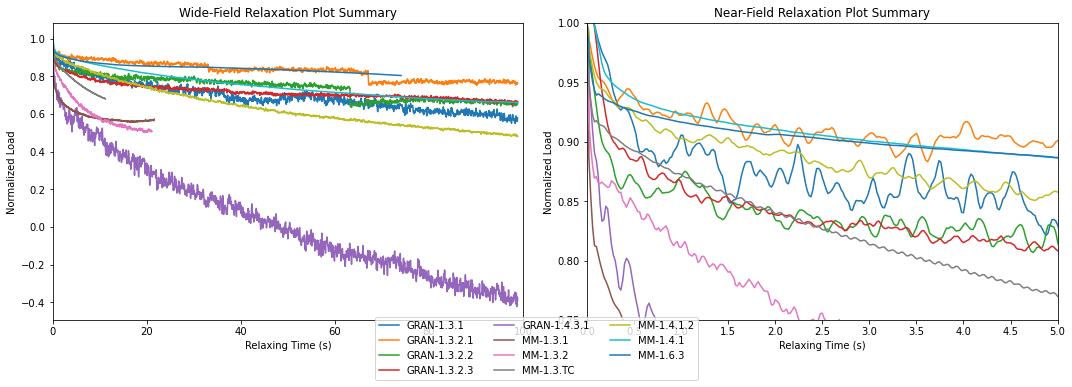

In [14]:
def plot_relaxation_summary(df):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    load_columns = [col for col in df.columns if col not in ['Relaxing Time']]

    lines = []  # Store lines for the legend
    labels = []  # Store labels for the legend

    for load_col in load_columns:
        line1, = ax1.plot(df['Relaxing Time'], df[load_col], label=load_col)
        ax2.plot(df['Relaxing Time'], df[load_col], label=load_col)
        lines.append(line1)
        labels.append(load_col)

    #Wide-Field Relaation Plot from 0 to 100 seconds
    ax1.set_xlabel('Relaxing Time (s)')
    ax1.set_xlim(0, 100)
    ax1.set_ylabel('Normalized Load')
    plt.margins(0)
    ax1.set_title('Wide-Field Relaxation Plot Summary')

    #Near-Field Relaation Plot from 0 to 5 seconds
    ax2.set_xlabel('Relaxing Time (s)')
    ax2.set_xlim(0, 5)
    ax2.set_ylabel('Normalized Load')
    plt.margins(0)
    ax2.set_ylim(0.75,1)
    ax2.set_title('Near-Field Relaxation Plot Summary')
    
    # Set custom tick positions with 0.5 increments
    ax2.set_xticks(np.arange(0, 5.1, 0.5))  
    
    #Place a single legend for both subplots at lower center of figure
    fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, 0.1), ncol=3)

    fig.tight_layout()
    fig.subplots_adjust(bottom=0.25)

    plt.show()

plot_relaxation_summary(relaxation_summary_df)


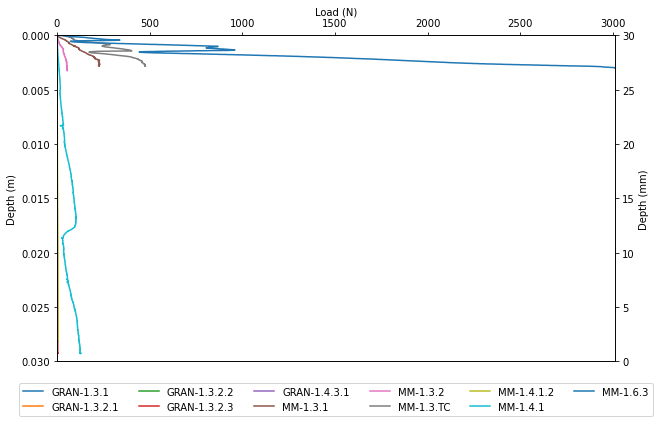

In [13]:
def plot_penetration_summary(df):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    load_columns = [col for col in df.columns if col not in ['Time', 'Depth']]

    for load_col in load_columns:
        ax1.plot(df[load_col], df['Depth'], label=load_col)

    ax1.set_ylabel('Depth (m)')
    ax1.invert_yaxis()
    ax1.set_ylim(0.03, 0)
    ax1.xaxis.set_ticks_position('top') # Move x-axis label to the top
    ax1.xaxis.set_label_position('top') # Move x-axis label to the top
    ax1.set_xlabel('Load (N)')
    ax1.tick_params(axis='x', labelbottom=False) # Hide x-axis label from the bottom
    plt.margins(0)

    # Add secondary y-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Depth (mm)')
    ax2.set_ylim(0.03*1000, 0*1000)
    ax2.invert_yaxis()

    # Place the legend centered beneath the axes
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=6)

    plt.show()

# Call the function to plot the penetration summary data
plot_penetration_summary(penetration_summary_df)


In [5]:
#If error : ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.
#Use this code - eliminates/skips error, makes it more fullproof

def slice_and_smooth(df, relaxation_point_index):
    ########################################################################
    #######         Slicing
    ########################################################################
    
    #Slice raw data based on Relaxation Point
    df['Penetration Regime Load Sliced'] = df['Load'][:relaxation_point_index]
    
    #Slice data from from Relaxation Point to End --- include -1 so that it INCLUDES RP_index 
    df['Relaxation Regime Load Sliced'] = df['Load'][relaxation_point_index - 1:]
    
    ########################################################################
    ####### Penetration Regime Smoothing
    ########################################################################
    
    # For SavGol Filtering, allocate Raw Penetration Regime Sliced data as a variable
    penetration_regime_load = df['Load'][:relaxation_point_index]

    # Check if the length of the penetration_regime_load is less than the desired window_length
    if len(penetration_regime_load) < 11:
        print(f"Skipping smoothing for this file, penetration_regime_load length is {len(penetration_regime_load)}, which is shorter than the desired window_length.")
        df['Load Smoothed'] = np.concatenate((penetration_regime_load.values, np.full((len(df) - len(penetration_regime_load)), np.nan)))
    else:
        # Apply Savgol filter with window length 11 and polynomial order 2
        penetration_regime_load_smoothed = savgol_filter(penetration_regime_load, window_length=11, polyorder=2)

        # Assign smoothed values to a new column in df
        df['Load Smoothed'] = np.concatenate((penetration_regime_load_smoothed, np.full((len(df) - len(penetration_regime_load_smoothed)), np.nan)))

    return df


SyntaxError: invalid syntax (<ipython-input-5-37c077cfe38e>, line 1)

In [ ]:
################# This code works as at 7:00pm on 07/05/2023
                        # It processes several .csv files, saves the data as summary excel sheets
                        # Slices FC_RP Penetration regime and normalizes relaxation regime
#DONE ----- Normalize Relaxation data
#DONE ----- Create summary sheets for Penetration and Relaxation Data
#DONE ----- Create point of first contact
#DONE -----Create FC to RP penetration Regime
    # Zero to FC as 0.00 extension?
# Create summary file with:
    # Firct Contact, FC Smooth, MP, MP Smooth, RP, RP Smooth, 
    # Polyfit Alpha and Beta
    # Near-Field and Wide-Field Relaxation Summary files?
#Calculate Tip Penetration Resistance (q_c) 
    #How does it vary fore different angle of frction (phi, Φ) or ice morphology?
# Plot with Resistance/Load on top X-axis, then depth going from 0 to base on Y-Axis
# Edit Combined Figure so that it has highlighted background like Regimes in 2018 Atkinson UCS paper

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import os
import statistics
from scipy.stats import mode
import openpyxl

#For self checking and code development
import datetime

################################################################################
################################################################################
#                         Define Functions
################################################################################
################################################################################

# Define the function to read in a data file and return a cleaned dataframe
def read_data_file(filepath):
    # read the csv file into a pandas dataframe
    df = pd.read_csv(filepath, header=6).drop([0]).astype(float)

    # Make sure Time is 0.00 (The Exported .CSV files have Time since program opened, not actual test time)
    # Round it to 2 decimal points, to assist with comparing different data
    df['Time'] = df['Time'] - df.iloc[0]['Time']
    df['Time'] = df['Time'].round(3)

    # Make sure Extension is 2 decimal points, to assist with determining Relaxation Point (RP)
    df['Extension'] = df['Extension'].round(2)

    return df

# Define the function to find the relaxation point
def find_relaxation_point(df):
    mode_value = mode(df['Extension'])[0][0]
    relaxation_point_index = df['Extension'].index[df['Extension'] == mode_value][0] - 1
    return relaxation_point_index

def slice_and_smooth(df, relaxation_point_index):
    ########################################################################
    #######         Slicing
    ########################################################################
    
    #Slice raw data based on Relaxation Point
    df['Penetration Regime Load Sliced'] = df['Load'][:relaxation_point_index]
    
    #Slice data from from Relaxation Point to End --- include -1 so that it INCLUDES RP_index 
    df['Relaxation Regime Load Sliced'] = df['Load'][relaxation_point_index - 1:]
    
    ########################################################################
    ####### Penetration Regime Smoothing
    ########################################################################
    
    # For SavGol Filtering, allocate Raw Penetration Regime Sliced data as a variable
    penetration_regime_load = df['Load'][:relaxation_point_index]

    # Apply Savgol filter with window length 21 and polynomial order 3
    penetration_regime_load_smoothed = savgol_filter(penetration_regime_load, window_length=11, polyorder=2)

    # Assign smoothed values to a new column in df
    df['Load Smoothed'] = np.concatenate((penetration_regime_load_smoothed, np.full((len(df) - len(penetration_regime_load_smoothed)), np.nan)))

    #relaxation_point_load_smoothed = df.loc[relaxation_point_index, 'Load Smoothed']
        
    ########################################################################
    ####### Relaxation Regime Smoothing
    ########################################################################
    #Determine Start time (0.00 sec) of Relaxation Regime based on Relaxation Point Index in Raw Data
    df['Relaxing Time'] = df['Time'] - df.loc[relaxation_point_index, 'Time']
    df['Relaxing Time'] = df['Relaxing Time'].round(3)

    #Create new dataframe 
    df_relax = df.loc[relaxation_point_index:, ['Relaxing Time','Relaxation Regime Load Sliced']].reset_index(drop=True)

    #Smooth Relaxation Regime Data
    df_relax['Relaxation Regime Load Smoothed'] = savgol_filter(df_relax ['Relaxation Regime Load Sliced'], window_length=11, polyorder=2, mode='nearest')

    # Replace the first value of the smoothed load column with the first value of the sliced load column
    df_relax.loc[0, 'Relaxation Regime Load Smoothed'] = df_relax .loc[0, 'Relaxation Regime Load Sliced']
    
    #Determine Normalized Load Raw Data against Load value at Relaxation Point Index in Raw Data
    df_relax['Normalized Load Raw'] = df_relax['Relaxation Regime Load Sliced'] / df_relax.loc[0, 'Relaxation Regime Load Sliced']
    #Determine Normalized Load Smoothed Data
    df_relax['Normalized Load Smoothed'] = df_relax['Relaxation Regime Load Smoothed'] / df_relax.loc[0, 'Relaxation Regime Load Smoothed']

    return df, df_relax    

def find_first_contact (df,relaxation_point_index):
    # Calculate the change in mm/N
    df['Rate of Loading (mm/N)'] = abs(df['Extension'] / df['Load Smoothed'])

    # Determine the index of First Contact Point (FP) (Absolute max value of loading rate within Range of 0 to 10 mm extension)
    first_contact_index = df[(df['Extension'] >= 0) & (df['Extension'] <= 5)]['Rate of Loading (mm/N)'].abs().idxmax()
    
    #Create new ZERO reference for Time and Extension for Smoothed Penetration Regime (First Contact to RP)
    df['Time - FC_RP Penetration Regime'] = df['Time'] - df.iloc[first_contact_index - 1]['Time']
    df.loc[df.index < first_contact_index, 'Time - FC_RP Penetration Regime'] = np.nan
    
    df['Extension - FC_RP Penetration Regime'] = df['Extension'] - df.iloc[first_contact_index - 1]['Extension']
    df.loc[df.index < first_contact_index, 'Extension - FC_RP Penetration Regime'] = np.nan

    #Slice data from from First Contact (Smoothed) to RP --- include ??? so that it INCLUDES RP_index 
    df['Load - Penetration Regime FC_RP'] = df['Load Smoothed'][first_contact_index - 1: relaxation_point_index]
    
    return df, first_contact_index

def process_data_file(filename):
    filepath = os.path.join(folder_path, filename)
    # Read in the data and clean it
    df = read_data_file(filepath)
    
    # Find the relaxation point and slice and smooth the data
    relaxation_point_index = find_relaxation_point(df)
    
    #Initial Slice and Smooth Data for smoothed/normalized relaxation curve and pre-sliced penetration regime (Start to RP)
    df, df_relax = slice_and_smooth(df, relaxation_point_index)
    
    #Find First Contact and slice penetration regime (FC to RP)
    df, first_contact_index = find_first_contact(df,relaxation_point_index)

    return df, df_relax, first_contact_index, relaxation_point_index


def save_dataframes_to_excel(dfs, output_file):
    # Create an Excel writer object
    writer = pd.ExcelWriter(output_file, engine='openpyxl')

    # Iterate through the dataframes in the dictionary and write them to the Excel file
    for sheet_name, df in dfs.items():
        df.to_excel(writer, sheet_name=sheet_name)

    # Save the Excel file
    writer.save()
    
def create_penetration_summary_sheets(dfs, output_file, first_contact_index, relaxation_point_index):
    # create an empty dictionary to hold the summary data
    penetration_summary_dict = {}

    # iterate over each dataframe in dfs
    for filename, df in dfs.items():
        # slice the data between the first_contact_index and relaxation_point_index and extract the "Load - Penetration Regime FC_RP" column
        penetration_summary_dict[filename] = df['Load - Penetration Regime FC_RP']

    # concatenate all the dataframes together into a single summary dataframe
    penetration_summary_df = pd.concat(penetration_summary_dict, axis=1)
    
    # insert the "Time - FC_RP Penetration Regime" column from one dataframe to the beginning of the summary dataframe
    first_file = list(dfs.keys())[0]
    penetration_summary_df.insert(0, "Time - FC_RP Penetration Regime", dfs[first_file]['Time - FC_RP Penetration Regime'])

    # write the summary dataframe to a new sheet in the output Excel file
    with pd.ExcelWriter(output_file, engine='openpyxl', mode='a') as writer:
        penetration_summary_df.to_excel(writer, sheet_name='Summary', index=True)

    
def create_relaxation_summary_sheets(dfs_relax, output_file):
    # create an empty dictionary to hold the summary data
    relaxation_summary_dict = {}
    
    # iterate over each dataframe in dfs_relax
    for filename, df in dfs_relax.items():
        # extract the "Relaxation Regime Load Smoothed" column
        relaxation_summary_dict[filename] = df['Normalized Load Smoothed']##################### < SMoothed or Raw???
    
    # concatenate all the dataframes together into a single summary dataframe
    relaxation_summary_df = pd.concat(relaxation_summary_dict, axis=1)
    
    # insert the "Relaxing Time" column from one dataframe to the beginning of the summary dataframe
    first_file = list(dfs_relax.keys())[0]
    relaxation_summary_df.insert(0, "Relaxing Time", dfs_relax[first_file]['Relaxing Time'])
    
    # write the summary dataframe to a new sheet in the output Excel file
    with pd.ExcelWriter(output_file, engine='openpyxl', mode='a') as writer:
        relaxation_summary_df.to_excel(writer, sheet_name='Summary', index=True)



################################################################################
################################################################################
#                         Run For Loop
################################################################################
################################################################################
# set the path to the folder containing the csv files
folder_path = './Raw Files/'

# create figures and directories if they don't exist
#if not os.path.exists("Figures"):
    #os.mkdir("Figures")

# Define Dictionary
dfs = {}
dfs_relax = {}

for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        df, df_relax, first_contact_index, relaxation_point_index= process_data_file(filename)
        
        # Store the dataframes in the dictionaries with the file name as the key
        dfs[filename] = df
        dfs_relax[filename] = df_relax

# Save dataframes to Excel Files within a 'Processed Files' folder
if not os.path.exists("Processed Data"):
    os.mkdir("Processed Data")

#Save output variable as Excel file
output_file = os.path.join("Processed Data", "Penetration Regimes Summary.xlsx")
output_file_relax = os.path.join("Processed Data", "Relaxation Regimes Summary.xlsx")

#Save processed dataframes for Penetration and Resistance data to to single Excel file
save_dataframes_to_excel(dfs, output_file)
save_dataframes_to_excel(dfs_relax, output_file_relax)

#create summary sheets in existing Excel File
create_penetration_summary_sheets(dfs, output_file, first_contact_index, relaxation_point_index)
create_relaxation_summary_sheets(dfs_relax, output_file_relax)

############

# get the current date and time
now = datetime.datetime.now()

# format the date and time
formatted_date_time = now.strftime("%Y-%m-%d %H:%M:%S")

# print the formatted date and time
print("Current date and time: ", formatted_date_time)
#Print success
print(f"Penetration data saved to {output_file}")
print(f"Relaxation  data saved to {output_file_relax}")

# Spare Code Bits

In [ ]:
#Function to call dataframe and plot

def read_summary_sheet(file_path, sheet_name='Summary'):
    return pd.read_excel(file_path, sheet_name=sheet_name)

penetration_summary_file = "Processed Data/Penetration Regimes Summary.xlsx"
relaxation_summary_file = "Processed Data/Relaxation Regimes Summary.xlsx"

penetration_summary_df = read_summary_sheet(penetration_summary_file)
relaxation_summary_df = read_summary_sheet(relaxation_summary_file)

def plot_summary_data(df, columns_to_plot, x_col, ylabel, title):
    plt.figure(figsize=(10, 6))

    for col in columns_to_plot:
        plt.plot(df[x_col], df[col], label=col)

    plt.xlabel(x_col)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

    # Plot the penetration data
plot_summary_data(
    penetration_summary_df,
    penetration_summary_df.columns[2:],
    "Time",
    "Penetration Load (N)",
    "Penetration Regime Data"
)

# Plot the relaxation data
plot_summary_data(
    relaxation_summary_df,
    relaxation_summary_df.columns[1:],
    "Relaxing Time",
    "Normalized Load",
    "Relaxation Regime Data"
)
